DHBW Ravensburg - WWIDS119 - Machine Learning Project - Milan Wosel & Ngoc My Tran

# Dataset 2

### Application of a neural network on the Airbus satellite imagery dataset on wind turbines

For this project the CRISP-DM method was used.

## Business Case

Nowdays wind turbines are used to generate electricity. With help of them global warming can be combatted.
That is one of the reasons why states and companies are investing more and more into renewable energies. Their goal is to construct more wind turbines.

An advantage would be to know if there are any wind turbines at some locations.

That is why we would like to create a machine learning model which tell us where wind turbines are and where not. In that case we can provide the state and companies data for them to know where wind turbines are still needed and where else they could be built. Furthermore one can see how many wind turbines Germany has in order to make a comparison to other countries.

To reach the goal deep learning will be used to identify wind turbines on the satellite images. 

## Install and Import Libraries

In [3]:
# !pip install opendatasets

# !pip install pandas
# !pip install numpy
# !pip install tensorflow

# !pip install seaborn
# !pip install matplotlib

# !pip install pillow

#!pip install split-folders

In [6]:
import opendatasets as od
import os
import re
from PIL import Image

import splitfolders

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

### Information about the Dataset

- consists of images with and without turbines
- the images without turbines are just backgrounds such as meadows, water, etc.

- resolution: 1.5 meters per pixel
- image size: 128x128 pixels
--> sections represent approx. 192m on the ground

Without turbines:
- 202.565 training images
- 40.513 validation images

With turbines:
- 154.942 training images
- 30.991 validation images

### Download Dataset

In [7]:
# download the dataset from Kaggle
def downloadDataSet():
    url  = "https://www.kaggle.com/datasets/airbusgeo/airbus-wind-turbines-patches/download"
    path = "airbus-wind-turbines-patches"
    
    if os.path.exists(path):
        print("File already downloaded")
    else:
        od.download(url)
        print("File successfully downloaded")

In [8]:
def renameDirectory():
    path="airbus-wind-turbines-patches"
    
    if(os.path.exists(os.path.join(path, "train/windturbine"))):
        print("Folder already renamed")
    else:
        os.rename(os.path.join(path, "train/target"), os.path.join(path, "train/windturbine"))
        os.rename(os.path.join(path, "val/target"), os.path.join(path, "val/windturbine"))
        print("Folder successfully renamed")

In [9]:
downloadDataSet()
renameDirectory()

File already downloaded
Folder already renamed


### Load Dataset

#### Keras ImageLoader

In [10]:
img_height = 128
img_width  = 128
batch_size = 15

In [11]:
def loadDataset():
    path_train = "airbus-wind-turbines-patches/train"
    path_val   = "airbus-wind-turbines-patches/val"
    return image_dataset_from_directory(path_train, batch_size=batch_size, image_size=(img_height, img_width)), image_dataset_from_directory(path_val, image_size=(img_height, img_width))

In [12]:
train_DS, val_DS = loadDataset()

Found 357507 files belonging to 2 classes.


2022-05-26 21:40:30.264996: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-26 21:40:35.569025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3718 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1c:00.0, compute capability: 7.5
2022-05-26 21:40:35.572185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9329 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1d:00.0, compute capability: 7.5
2022-05-26 21:40:35.573984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

Found 71504 files belonging to 2 classes.


In [13]:
class_names = train_DS.class_names
print(class_names)

['background', 'windturbine']


### Verify the Data

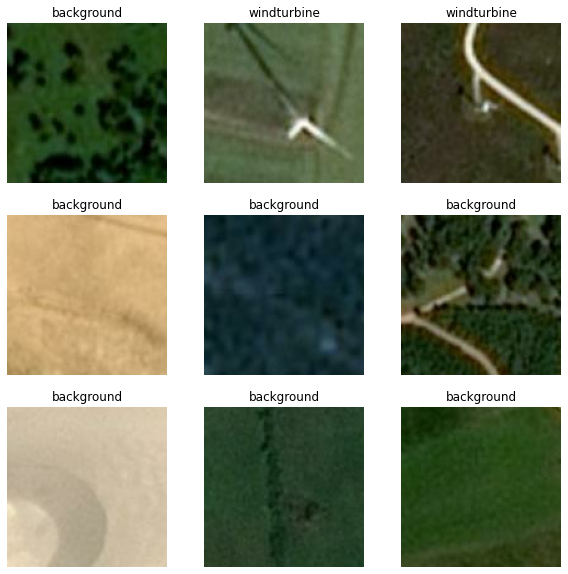

In [14]:
# plot some images to see if the data is correct

plt.figure(figsize=(10, 10))

for images, labels in train_DS.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Analysis

In [75]:
shape = None

for image_batch, labels_batch in train_DS:
    shape = image_batch.shape
    
    print(shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())
    
    break
    
    print(shape)

(15, 128, 128, 3)
(15,)
[1 0 1 1 0 1 0 0 0 0 0 0 0 1 1]
(15, 128, 128, 3)


In [15]:
listImages = os.listdir("airbus-wind-turbines-patches/train/windturbine")
print(listImages[0])

aa9957d2-87cc-4b4c-b98e-cc7b6b745bb6.jpg


In [20]:
number_classes = {
    'Windturbine_TRAIN': len(os.listdir(os.path.join(p_train, p_target))),
    'Background_TRAIN' : len(os.listdir(os.path.join(p_train, p_background))),
    'Windturbine_EVAL' : len(os.listdir(os.path.join(p_eval, p_target))),
    'Background_EVAL'  : len(os.listdir(os.path.join(p_eval, p_background))),
}

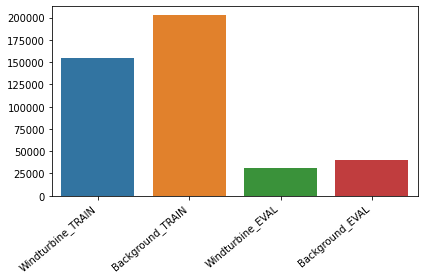

In [19]:
keys = list(number_classes.keys())
values = list(number_classes.values())

ax = sns.barplot(x=keys, y=values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

## Data Preprocessing

Since all the images have the same format no normalization or reshaping is needed.

### Data Augmentation

Data Augmentation is used to create create more data in order to get a better accuracy of the model. But since the dataset consists of a lot of images in different variation this techniques isn't necessary in this case.

## Train Modell

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_DS = train_DS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_DS = val_DS.cache().prefetch(buffer_size=AUTOTUNE)

In [82]:
print(shape[1:])
print(shape)

(128, 128, 3)
(15, 128, 128, 3)


### Train - Validate - Test - Split

In total the dataset consists of 429.011 images. They are splittet into a training and validation set with a ratio of 80% - 20% which is a good training - test ratio. That's why the validation set is used as the test set for the evaluation. The training set will be devided into training and validation set with a 80% - 20% as well.

##### 1st Try

In [20]:
type(listImages)

list

In [28]:
len(listImages) #training dataset # background

154942

In [22]:
import random

random.shuffle(listImages)

In [26]:
split = int(0.8 * len(listImages))

train_filenames = listImages[:split]
test_filenames = listImages[split]

In [47]:
# move to another folder

Quelle: https://cs230.stanford.edu/blog/split/

##### 2nd Try

In [30]:
train_windturbine = os.listdir("airbus-wind-turbines-patches/train/windturbine")
train_background = os.listdir("airbus-wind-turbines-patches/train/background")
val_windturbine = os.listdir("airbus-wind-turbines-patches/val/windturbine")
val_background = os.listdir("airbus-wind-turbines-patches/val/background")

In [31]:
train_windturbine[2]

'530ab9f4-5e77-42f3-aa03-671548d0e534.jpg'

In [46]:
import shutil

#os.makedirs("airbus-wind-turbines-patches/test/windturbine")
#os.makedirs("airbus-wind-turbines-patches/test/background")

allFileNames = train_windturbine

np.random.shuffle(allFileNames)

test_ratio = 0.20

train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])

'airbus-wind-turbines-patches/test/windturbine/windturbine'

In [45]:
test_FileNames

array(['8207ae92-abf3-4485-aca8-dd8aaf0be664.jpg',
       'c05afb38-5015-499a-99b7-816cbb91b2d4.jpg',
       '8c556d42-5900-490f-bcdb-f4d8c3a91587.jpg', ...,
       '1239fc26-a144-4422-93e1-6078fa7e9f28.jpg',
       '8e7db0ff-9442-4e69-b18f-1a3e9185a2f4.jpg',
       'be17a702-d938-4a4c-b16e-6edbeafcd22f.jpg'], dtype='<U40')

In [ ]:
# shutil.move(source, destination)

Quelle: https://www.kaggle.com/questions-and-answers/102677

##### Further Tries

- https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets
- https://pypi.org/project/split-folders/
- https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/
- https://www.quora.com/How-can-I-split-my-image-datasets-into-training-validation-and-testing-sets-for-Neural-Network-CNN-in-python
- https://www.kaggle.com/questions-and-answers/102677
- https://cs230.stanford.edu/blog/split/

### Create CNN

In [83]:
num_classes = len(class_names)

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=shape[1:]),
    layers.Dense(num_classes1)
])

In [45]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    
    # The second convolution
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # The third convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # # The fifth convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [55]:
# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential([
    layers.add(Conv2D(32, (5,5), activation='relu', input_shape=(img_height, img_width,3))),
    layers.add(Conv2D(32, (5,5), strides = (2,2), activation ='relu'))
    layers.add(MaxPooling2D(pool_size(2,2)), activation="relu")
    layers.add(Dropout(0.25))
    layers.add(Flatten())
    layers.add(Dense(512))
    layers.add(activation('relu'))
    layers.add(Dropout(0.5))
    layers.add(Dense(num_classes), activation("softmax"))
])

# display te architecture of the model
model_1.summary()

SyntaxError: invalid syntax (433887058.py, line 6)

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
# display te architecture of the model
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 64)      

### Train Model

In [ ]:
epochs=10

history = model.fit(train_DS, validation_data=val_DS, epochs=epochs)

### Old Shit

In [ ]:
def create_dataset(path):
    images = []
    target = []
    imagePaths = []
    
    directory = os.listdir(path)
    
    for direc in directory:
        print(direc)
        
        for file in os.listdir(os.path.join(path, direc)):
            imagePath = os.path.join(path, direc, file)
            image = np.array(Image.open(os.path.join(path, direc, file)))
            images.append(image)
            
            if re.search("target", direc):
                target.append(1)
            else:
                target.append(0)
                
            imagePaths.append(imagePath)
            
    print("Done")

    return pd.DataFrame({'imagePaths':imagePaths, 'images':images, 'target':target}, columns=['imagePath', 'images', 'label'])

In [ ]:
dataset_train = create_dataset('C:/Users/milan/Documents/GitHub/Machine Learning Projects/Data/Wind-Turbine-Data/archive/train')
dataset_train.head()

dataset_eval = create_dataset("C:/Users/milan/Documents/GitHub/Machine Learning Projects/Data/Wind-Turbine-Data/archive/val")
dataset_eval.head()

### Transfer Learning

In [17]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

training = model.fit(train_DS, epochs=15, validation_data=val_DS)

Epoch 1/15
23834/23834 [==============================] - 419s 17ms/step - loss: 0.3342 - binary_accuracy: 0.9150 - val_loss: 0.2171 - val_binary_accuracy: 0.9360
Epoch 2/15
23834/23834 [==============================] - 416s 17ms/step - loss: 0.3091 - binary_accuracy: 0.9263 - val_loss: 0.2655 - val_binary_accuracy: 0.9277
Epoch 3/15
23834/23834 [==============================] - 416s 17ms/step - loss: 0.3115 - binary_accuracy: 0.9284 - val_loss: 0.3842 - val_binary_accuracy: 0.9120
Epoch 4/15
23834/23834 [==============================] - 416s 17ms/step - loss: 0.3129 - binary_accuracy: 0.9293 - val_loss: 0.4080 - val_binary_accuracy: 0.9165
Epoch 5/15
23834/23834 [==============================] - 418s 18ms/step - loss: 0.3138 - binary_accuracy: 0.9305 - val_loss: 0.2222 - val_binary_accuracy: 0.9467
Epoch 6/15
23834/23834 [==============================] - 415s 17ms/step - loss: 0.3174 - binary_accuracy: 0.9305 - val_loss: 0.2485 - val_binary_accuracy: 0.9432
Epoch 7/15
23834/23834

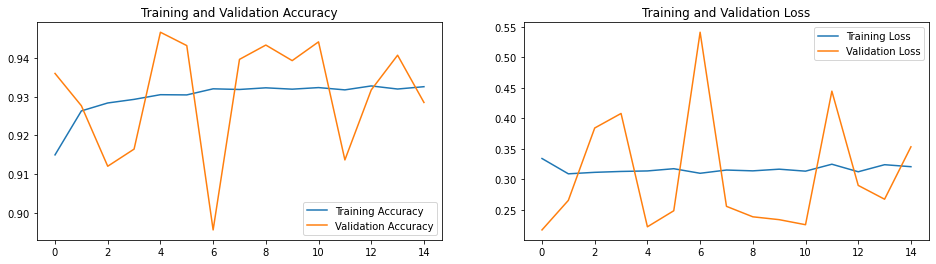

In [42]:
acc = training.history['binary_accuracy']
val_acc = training.history['val_binary_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
print(training.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [35]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

KeyError: 'acc'

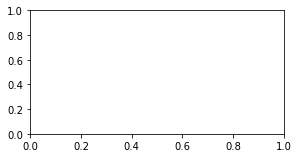

In [21]:
plot_accuracy_loss(training)

### Simple CNN Modell

In [30]:
model_simple = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [31]:
model_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = model_simple.fit(train_DS, validation_data=val_DS, batch_size=128, epochs=15)

Epoch 1/15
23834/23834 [==============================] - 159s 7ms/step - loss: 0.2167 - accuracy: 0.9553 - val_loss: 0.0875 - val_accuracy: 0.9723
Epoch 2/15
23834/23834 [==============================] - 158s 7ms/step - loss: 0.0843 - accuracy: 0.9733 - val_loss: 0.0919 - val_accuracy: 0.9718
Epoch 3/15
23834/23834 [==============================] - 157s 7ms/step - loss: 0.0763 - accuracy: 0.9771 - val_loss: 0.1114 - val_accuracy: 0.9741
Epoch 4/15
23834/23834 [==============================] - 155s 7ms/step - loss: 0.0635 - accuracy: 0.9799 - val_loss: 0.0775 - val_accuracy: 0.9792
Epoch 5/15
23834/23834 [==============================] - 158s 7ms/step - loss: 0.0582 - accuracy: 0.9818 - val_loss: 0.0995 - val_accuracy: 0.9752
Epoch 6/15
23834/23834 [==============================] - 159s 7ms/step - loss: 0.0550 - accuracy: 0.9833 - val_loss: 0.1077 - val_accuracy: 0.9731
Epoch 7/15
23834/23834 [==============================] - 154s 6ms/step - loss: 0.0492 - accuracy: 0.9845 - val_

In [34]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


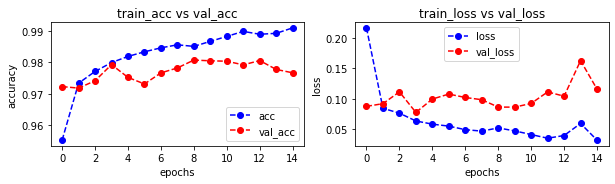

In [36]:
plot_accuracy_loss(history)

## Hyperparameter Tuning

## Regularization

Use Early Stopping to avoid overfitting.

## Conclusion

...

## Outlook

For further work the possibilities are:
- Image Detection: Detection of wind turbines on the images
- Classification of:
    - the type of windmil
    - the environment the wind turbines are in (water, land, etc.)
    - the direction of the wind